# Introduction
> The goal of this report is to create a prototype mechanism for the salamander leg movement and understand the kinematics/forces involved. In order for continuous progress to be made, the team decided to break down the problem into 2 main parts: the salamander body and salamander leg mechanisms. Initially we are assuming 4 actuators will be used with two being used to control the four limbs and two to control the front and rear sides of the spine body. Eventually once designs have progressed further, the number of actuators will be reduced by connecting the motion of the spine to the movement of the leg mechanism. The leg movement is the main focus of this report

## Salamander Limb Mechanism
> First a simple 2D planar version of the salamander leg was created using a 4-bar mechanism as inspiration.

## 1. Create a figure (either in python, in a vector-based drawing program like inkscape or illustrator, or as a solidworks rendering) of your system kinematics. Annotate the image:
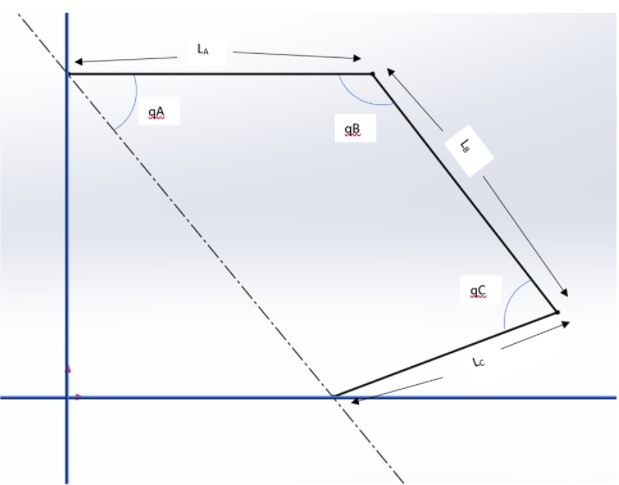
<center><b>Fig 1:</b> Shows the link lengths and joint variables</center>

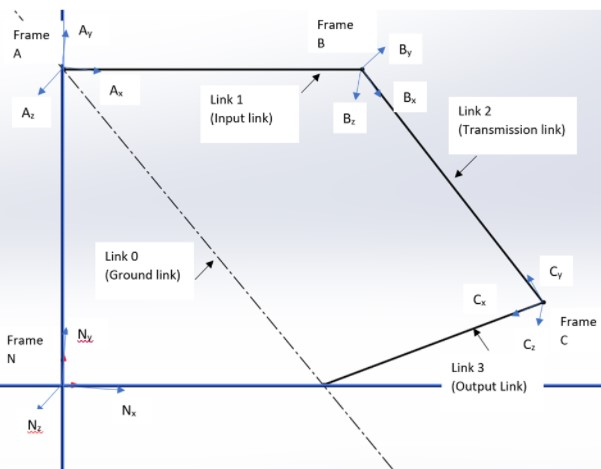
<center><b>Fig 2: </b>Shows links and frames</center>

## 2. Make the device in paper or cardboard. You need an up-to-date model if it has changed from your individual assignments. The paper model should dimensionally match your code.
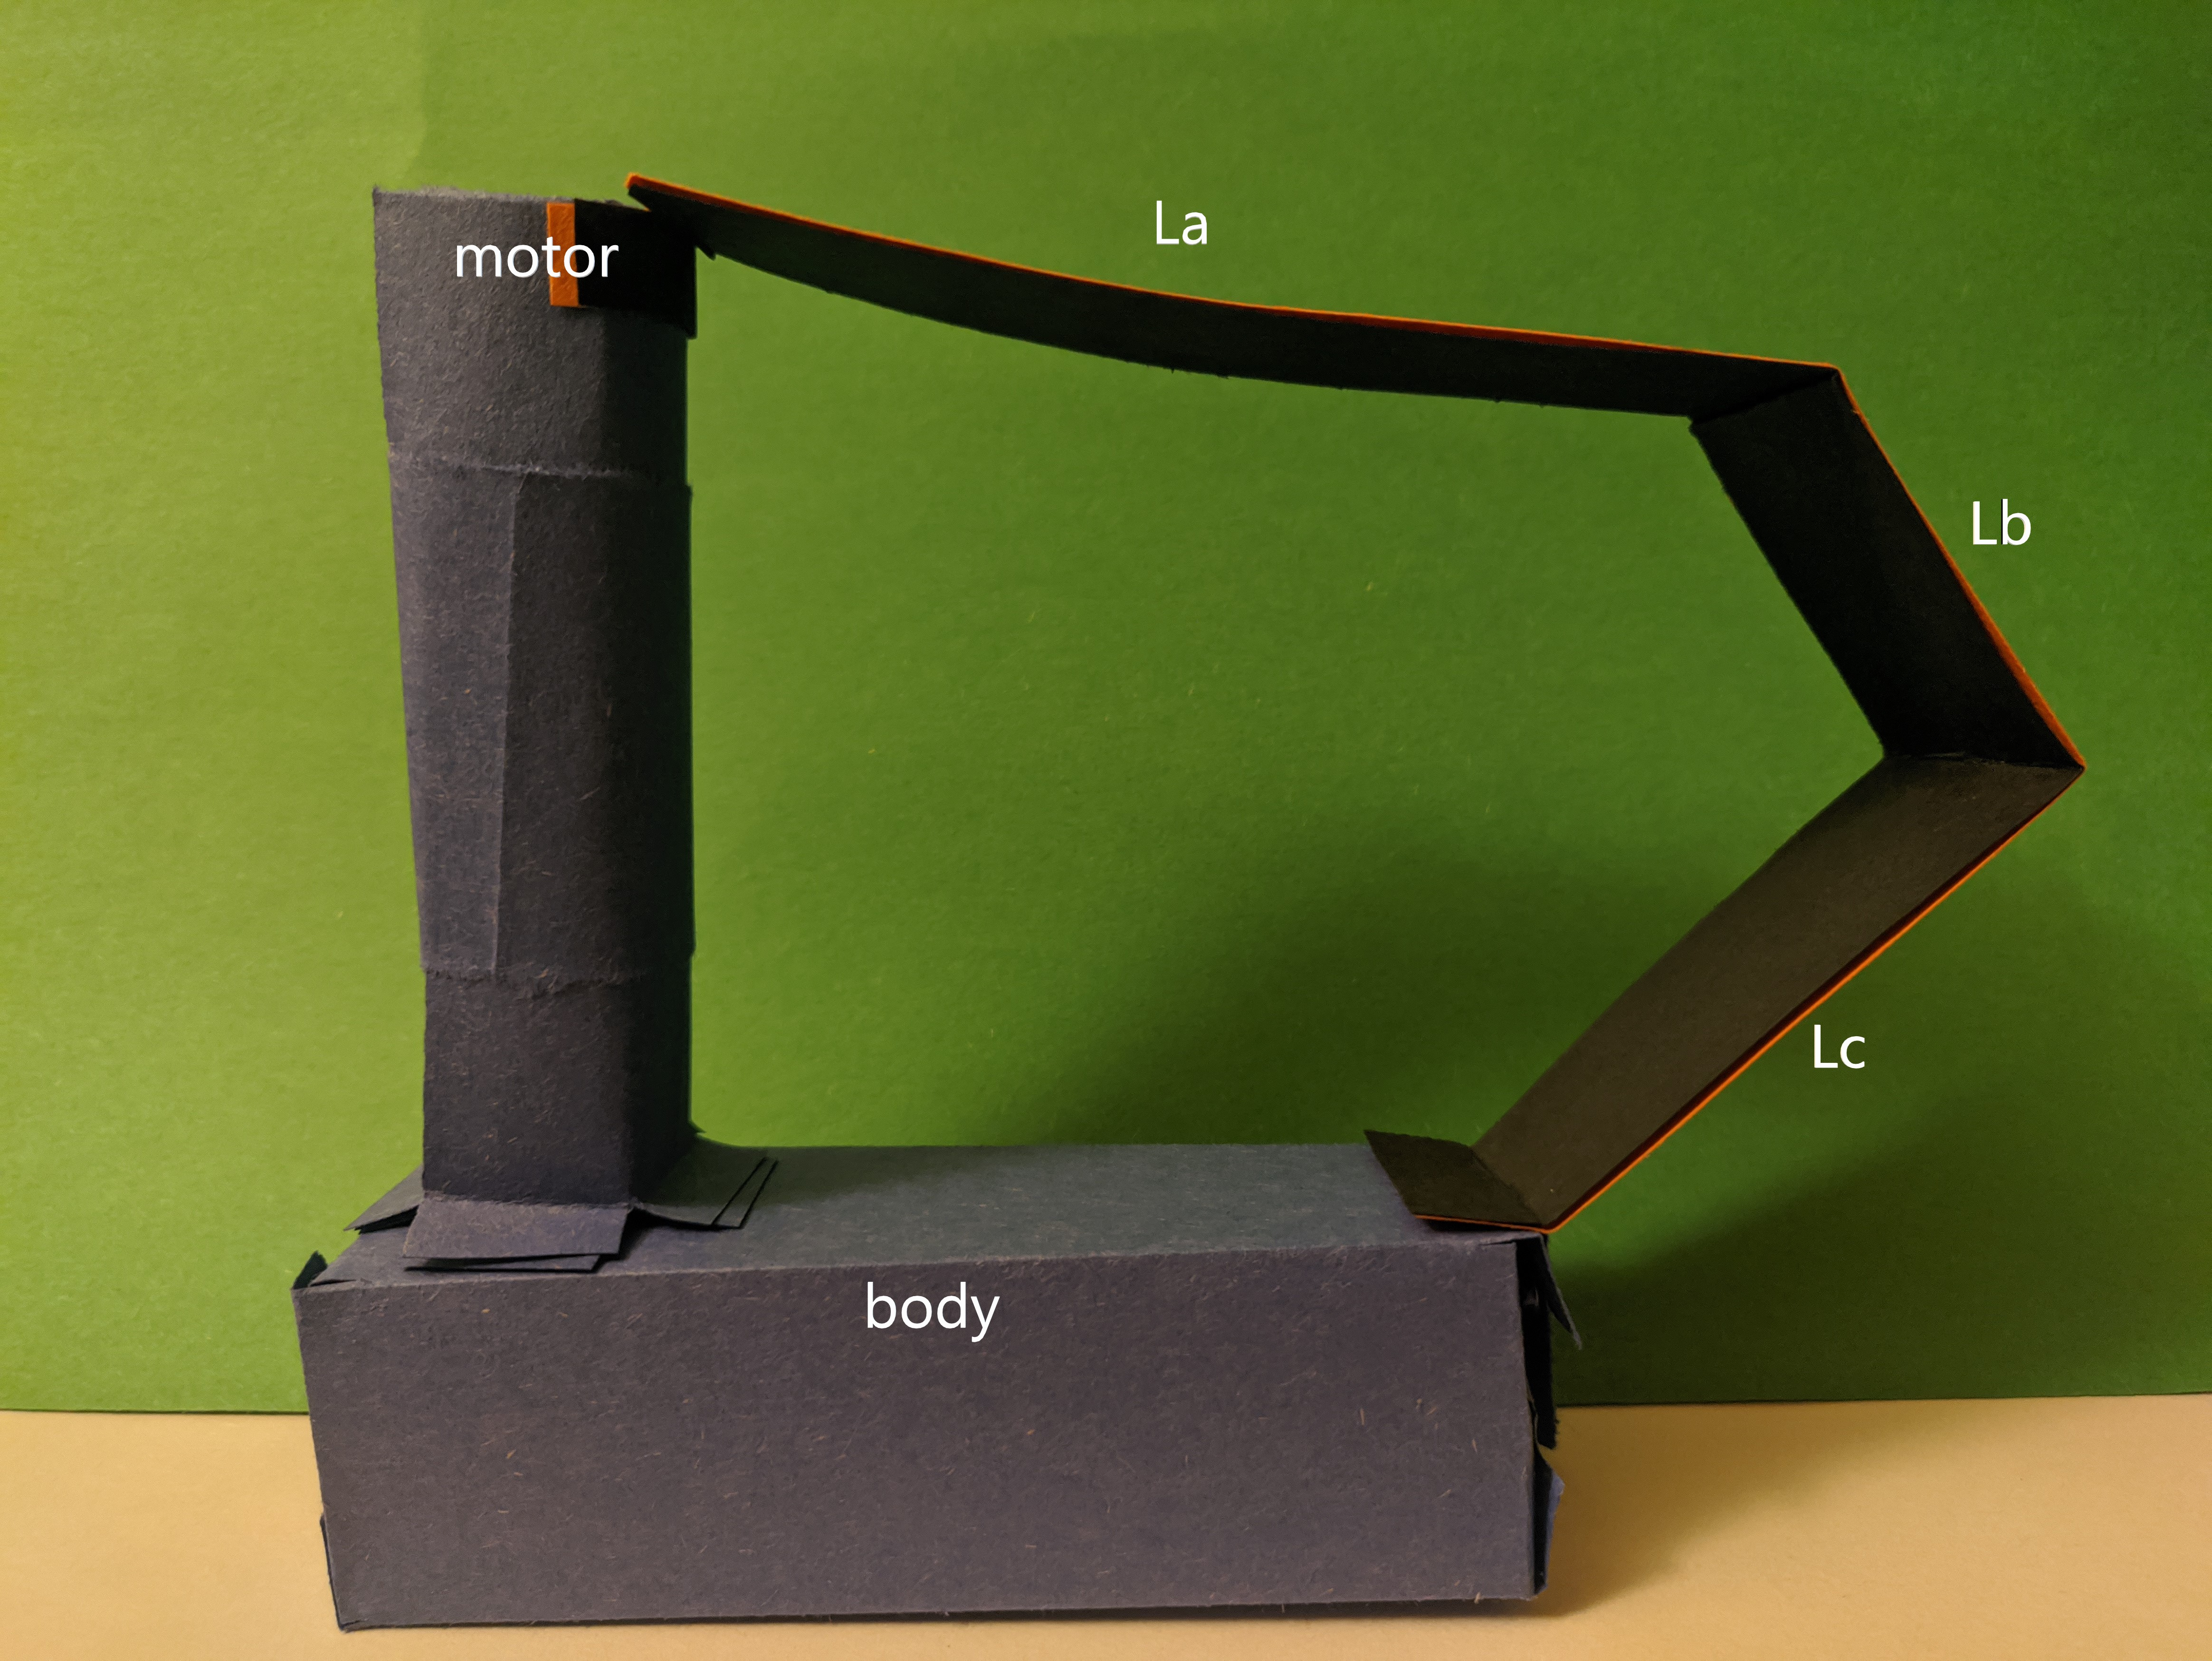

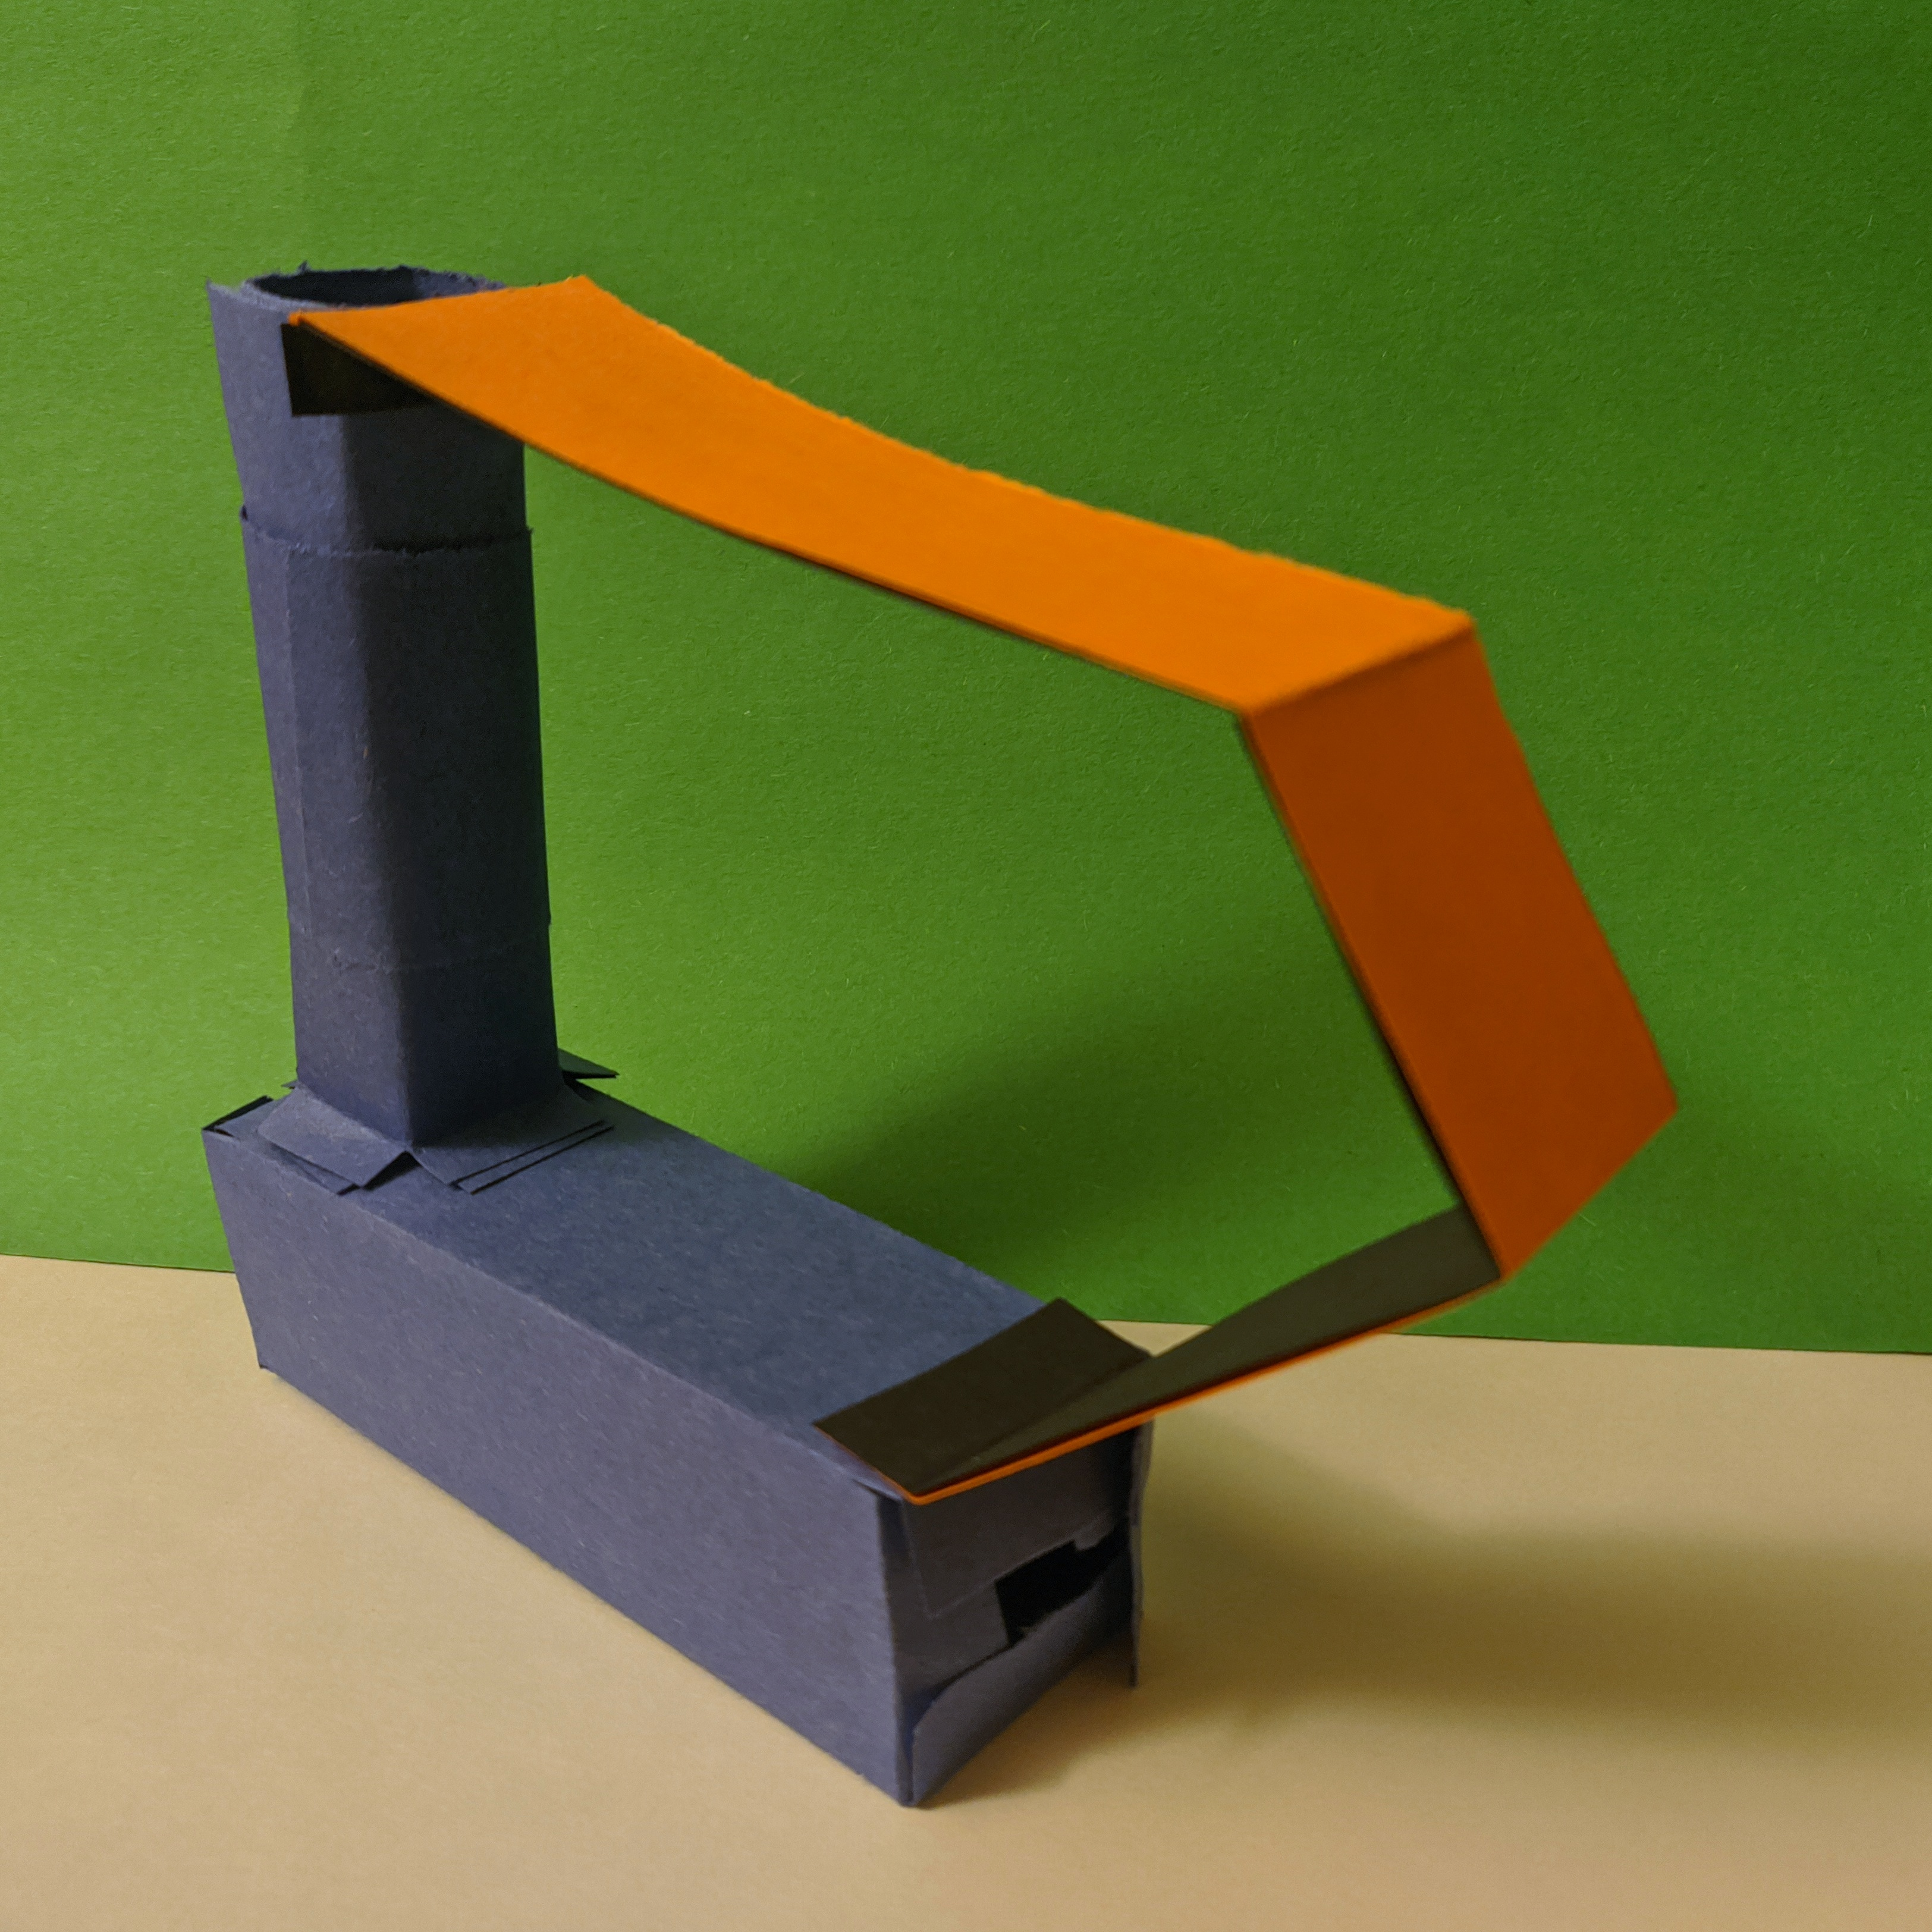
<center><b>Fig 3: </b>Paper model for proposed leg design</center>

## 3. Using a pynamics-based script, develop a kinematic model for your device. 

First we import packages.

In [1]:
%matplotlib inline
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import AccelerationConstraint
import pynamics.integration
import numpy
import sympy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
import scipy.optimize

In [2]:
system = System()
pynamics.set_system(__name__,system)

Then we defined our variabled and constants. The mechanism is effectively a four-bar mechanism.

In [3]:
lA = Constant(10,'lA',system)
lB = Constant(6,'lB',system)
lC = Constant(4,'lC',system)
lD = Constant(8,'lD',system)

mA = Constant(1,'mA',system)
mB = Constant(1,'mB',system)
mC = Constant(1,'mC',system)
mD = Constant(1,'mD',system)

g = Constant(0,'g',system)
b = Constant(1e2,'b',system)
k = Constant(5e2,'k',system)

preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(-45*pi/180,'preload2',system)
preload3 = Constant(-90*pi/180,'preload3',system)
preload4 = Constant(-45*pi/180,'preload4',system)

In [4]:
Ixx_A = Constant(1,'Ixx_A',system)
Iyy_A = Constant(1,'Iyy_A',system)
Izz_A = Constant(1,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)
Ixx_C = Constant(1,'Ixx_C',system)
Iyy_C = Constant(1,'Iyy_C',system)
Izz_C = Constant(1,'Izz_C',system)
Ixx_D = Constant(1,'Ixx_D',system)
Iyy_D = Constant(1,'Iyy_D',system)
Izz_D = Constant(1,'Izz_D',system)

torque = Constant(-1e2,'torque',system)
freq = Constant(1e0,'freq',system)

In [5]:
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)
qD,qD_d,qD_dd = Differentiable('qD',system)

initialvalues = {}
initialvalues[qA]=0*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=-45*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=-90*pi/180
initialvalues[qC_d]=0*pi/180
initialvalues[qD]=-45*pi/180
initialvalues[qD_d]=0*pi/180

statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

Then the frames and frame rotations were defined.

In [6]:
N = Frame('N',system)
A = Frame('A',system)
B = Frame('B',system)
C = Frame('C',system)
D = Frame('D',system)

system.set_newtonian(N)

A.rotate_fixed_axis(N,[0,0,1],qA,system)
B.rotate_fixed_axis(A,[0,0,1],qB,system)
C.rotate_fixed_axis(B,[0,0,1],qC,system)
D.rotate_fixed_axis(C,[0,0,1],qD,system)

Then the kinematics were composed based off of the geometry of the system.

In [7]:
pNA = 0*N.x
pAB = pNA + lA*A.x
pBC = pAB + lB*B.x
pCD = pBC + lC*C.x
pD = 9*N.x - lD*N.y

pAcm = pNA + lA/2*A.x
pBcm = pAB + lB/2*B.x
pCcm = pBC + lC/2*C.x
pDcm = 4.5*N.x - lD/2*N.y

In [8]:
eq_vector = [pCD-pD]

eq_scalar = []
eq_scalar.append((eq_vector[0]).dot(N.x))
eq_scalar.append((eq_vector[0]).dot(N.y))

qi = [qA]
qd = [qB,qC,qD]

constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

eq_scalar = [item.subs(constants) for item in eq_scalar]

error = (numpy.array(eq_scalar)**2).sum()

f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

guess = [initialvalues[item] for item in qd]
result = scipy.optimize.minimize(function,guess)
print(result.fun)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))

5.7987049215505685e-15


In [9]:
wNA = N.get_w_to(A)
wAB = A.get_w_to(B)
wBC = B.get_w_to(C)
wCD = C.get_w_to(D)

vCtip = pCD.time_derivative(N,system)

IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)
ID = Dyadic.build(D,Ixx_D,Iyy_D,Izz_D)

BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)
BodyD = Body('BodyD',D,pDcm,mD,ID,system)

In [10]:
# system.addforce(torque*sympy.sin(freq*2*sympy.pi*system.t)*A.z,wNA)
system.addforce(torque*A.z,wNA)

system.addforce(-b*wNA,wNA)
system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)
system.addforce(-b*wCD,wCD)

system.add_spring_force1(k,(qA-preload1)*N.z,wNA) 
system.add_spring_force1(k,(qB-preload2)*A.z,wAB)
system.add_spring_force1(k,(qC-preload3)*B.z,wBC)
system.add_spring_force1(k,(qD-preload4)*C.z,wCD)

system.addforcegravity(-g*N.y)

In [11]:
f,ma = system.getdynamics()

2022-02-21 23:41:44,087 - pynamics.system - INFO - getting dynamic equations


In [12]:
func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

2022-02-21 23:41:45,122 - pynamics.system - INFO - solving a = f/m and creating function
2022-02-21 23:41:45,369 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-02-21 23:41:45,471 - pynamics.system - INFO - done solving a = f/m and creating function
2022-02-21 23:41:45,472 - pynamics.system - INFO - calculating function for lambdas


In [13]:
tol = 1e-5
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [14]:
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2022-02-21 23:41:45,522 - pynamics.integration - INFO - beginning integration
2022-02-21 23:41:45,523 - pynamics.system - INFO - integration at time 0000.00
2022-02-21 23:41:45,638 - pynamics.integration - INFO - finished integration


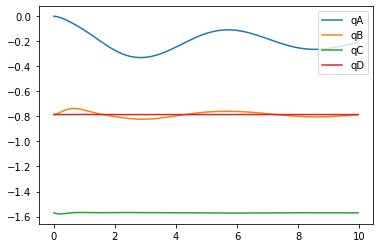

In [15]:
plt.figure()
artists = plt.plot(t,states[:,:4])
plt.legend(artists,['qA','qB','qC','qD'])

2022-02-21 23:41:45,964 - pynamics.output - INFO - calculating outputs
2022-02-21 23:41:45,978 - pynamics.output - INFO - done calculating outputs


<AxesSubplot:>

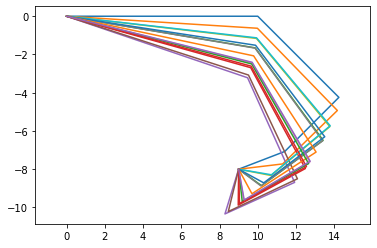

In [16]:
points = [pNA,pAB,pBC,pCD,pD]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

Due to problems with using symbolic language to define length/angle constraints, a script was used to numerically solve the kinematics with python that reflect a typical gait for a salamander. 

In [17]:
# This line produces inline images in jupyter notebook
%matplotlib inline
# import all the packages necessary for running the code
import numpy
import matplotlib.pyplot as plt
import scipy.optimize
import math

#Useful length constraint functions
def length(v1):
    '''
    finds the length of a vector
    
    :param v1: the vector
    :type v1: tuple or list of floats
    :rtypes: [float,] 
    '''
    v1 = numpy.array(v1).flatten()
    l = (v1.dot(v1))**.5
    return l

#Useful inner angle constraint function
def inner_angle(v1,v2):
    '''
    finds the interior angle between two vectors
    
    :param v1: the first vector
    :type v1: tuple or list of floats
    :param v2: the second vector
    :type v2: tuple or list of floats
    :rtypes: [float,] 
    '''
    v1 = numpy.array(v1).flatten()
    l1 = length(v1)
    v2 = numpy.array(v2).flatten()
    l2 = length(v2)
    cost = numpy.dot(v1,v2)/l1/l2
    t = math.acos(cost)
    return t

#Useful total angle constraint function
def total_angle(v1,v2,v3=None):
    '''
    finds the interior angle between two vectors
    
    :param v1: the first vector
    :type v1: tuple or list of floats
    :param v2: the second vector
    :type v2: tuple or list of floats
    :rtypes: [float,] 
    '''

    v1 = numpy.array(v1).flatten()
    if len(v1)==2:
        v1 = numpy.r_[v1,0]
        v3 = numpy.array([0,0,1])

        v2 = numpy.array(v2).flatten()
    if len(v2)==2:
        v2 = numpy.r_[v2,0]
        v3 = numpy.array([0,0,1])

    costheta = numpy.dot(v1,v2)
    sintheta  = numpy.cross(v1,v2)
    l_sintheta = length(sintheta)
    neg = sintheta.dot(v3)
    if neg<0:
        neg = -1
    else:
        neg=1
    theta = math.atan2(neg*l_sintheta,costheta)
    return theta  

#Useful angle between planes constraint function
def angle_between_planes(v1,v2,v3):
    '''measures the angle between planes.  
    v1 and v2 are two vectors which define one plane
    v2 and v3 define the third plane.'''
    
    n1 = numpy.cross(v1,v2)
    n2 = numpy.cross(v2,v3)
    return total_angle(n1,n2,v2)

#First the initial points were defined
p0_ini = 0,0
p1_ini = 1,0
p2_ini = 1.62,-.42
p3_ini = .88,-.57
p_ini = numpy.array([p0_ini,p1_ini,p2_ini,p3_ini])

point_text = ['A','B','C','D']

#Define a list of vectors by the index of the points used
vector_order = []
vector_order.append((0,1))
vector_order.append((1,2))
vector_order.append((2,3))
#vector_order.append((3,4))
vector_order = numpy.array(vector_order)

v_ini = p_ini[vector_order[:,1]]-p_ini[vector_order[:,0]]

#Calculate the initial length
l_ini = [length(item) for item in v_ini]

#Compute the text location as halfway between point 0 and 1 for each vector

text_location = (p_ini[vector_order[:,1]]+p_ini[vector_order[:,0]])/2

vector_text = ['LA','LB','LC']

#Create a function that plots a mechanism
def plot_mechanism(point_location,text_location=None):
    for item in vector_order:
        plt.plot(*(point_location[item,:3].T),'ko-')

    if text_location is not None:
        for item,text in zip(point_location,point_text):
            ax.text(x=item[0],y=item[1],s=text)

        for item,text in zip(text_location,vector_text):
            ax.text(x=item[0],y=item[1],s=text)

The initial mechanism was created and plotted below. The main constraints for this system were lengths of LA,LB, and LC. In addition points A and D were fixed. Then the angle q1 was altered to find the range of motion. In order to avoid singularities, the range of motion tested was 0 degrees to 120 degrees which is similar to the range in motion a salamander might have.

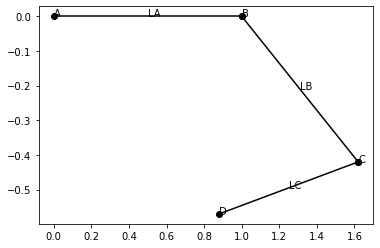

In [18]:
fig = plt.figure();
ax = fig.add_subplot(111)
plot_mechanism(p_ini,text_location)
plt.show()



In [19]:
#Adds constraints
def gen_function(q1,dl1,dl2,dl3):
    def calc_fourbar(arguments):
        # break arguments variable into 8 discrete variables, 2 for each planar point in the four-bar linkage
        x0,y0,x1,y1,x2,y2,x3,y3 = arguments
        
        #Create four points: p1, p2, p3, 
        p0 = numpy.array([x0,y0])
        p1 = numpy.array([x1,y1])
        p2 = numpy.array([x2,y2])
        p3 = numpy.array([x3,y3])
       

        
        #create new point array using inputs of function
        p = numpy.array([p0,p1,p2,p3])
        
        #create new vector array using vector ordering defined above
        v = p[vector_order[:,1]]-p[vector_order[:,0]]
        
        #create new length vector
        l = [length(item) for item in v]

        # Define the x and y axis unit vectors
        x_axis = numpy.array([1,0])
        y_axis = numpy.array([0,1])

        # define the error variable for holding all mechanism error calcs
        error = []

        # Compute the error in the structure as the absolute, cumulative 
        # difference between the link lengths and their desired lengths
        error.append([l[0]-dl1])
        error.append([l[1]-dl2])
        error.append([l[2]-dl3])
 

        
        # add the desired input angle q1 minus the actual angle as another error component to be solved
        error.append([total_angle(v[0],y_axis)-q1*math.pi/180])
        
        
        #error.append([inner_angle(-v[0],y_axis)-q1*math.pi/180+math.pi/2])
        
        # add two more constraints defining p1 as fixed at (0,0)
        error.append([p[0,0]-0])
        error.append([p[0,1]-0])
        
        # add two more constraints defining p3 as fixed at (.88,-.57)
        error.append([p[3,0]-.88])
        error.append([p[3,1]+.57])
        
        # define v1 to be parallel to the x axis.
        #error.append([inner_angle(v[0],x_axis)+90])

        # turn the error list into a vector
        error1 =numpy.array(error)
        
        # return the square root of the sum of squared errors.  The length function that we wrote earlier does that.
        return length(error1)
    
    return calc_fourbar

ini = list(p_ini.flatten())
design = numpy.array([1,.75,.75])
q1=90
function=gen_function(q1,*design)
result  = scipy.optimize.minimize(function,ini)
x = result.x
x =x.reshape((4,2))
result.fun

4.8930520219582455e-08

Constraints were added to the mechansim and tested with 90 degrees as shown below.

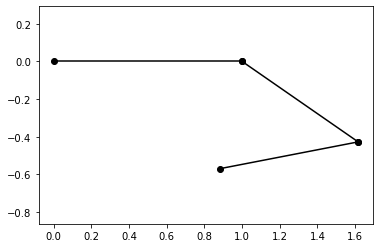

In [20]:
fig = plt.figure();
ax = fig.add_subplot(111)
#plot_mechanism(x,text_location)
plot_mechanism(x)
plt.axis('equal')
plt.show()

In [21]:
all_q = numpy.r_[0:120:10]
path = []
q_in = []
ini=result.x
for q1 in all_q:
    ini = list(p_ini.flatten())
    function=gen_function(q1,*design)
    result  = scipy.optimize.minimize(function,ini)
    points = result.x
    points =points.reshape((4,2))

    # Only add solution to path if the error is smaller than some nominal value
    print(result.fun)

    if result.fun<1e-1:
        path.append(points)
        q_in.append(q1)
        ini = result.x

path = numpy.array(path);
q_in = numpy.array(q_in);

0.13425260884410195
0.09300669161208122
0.04595128278106729
4.2750582047417536e-08
4.409750623713015e-08
4.1297999296325444e-08
5.1038503827875274e-08
4.067834285338898e-08
4.210054394228331e-08
4.8930520219582455e-08
4.070234600161679e-08
5.215635739179037e-08


The full range of motion for 0 to 120 degrees was plotted and shown below.

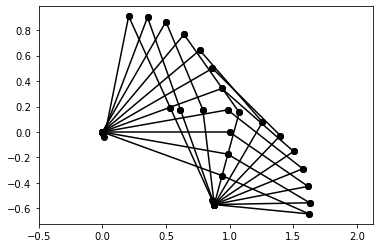

In [22]:
f = plt.figure()
a = f.add_subplot(111)
path2=path[:,2,:]
for item in path:
    plot_mechanism(item)
plt.axis('equal')
plt.savefig('f1.png')

The end-effector was determined to be point C since that is the joint that will be interacting with the environment. The path of just that joint was plotted below.

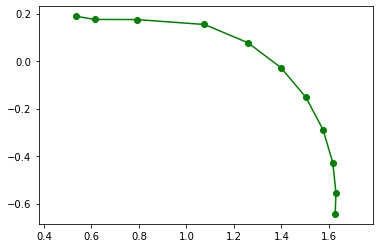

In [23]:
plt.figure()
p2 = path[:,2,:]
#p4 = numpy.r_[p4,p4[0:1]]
plt.plot(p2[:,0],p2[:,1],'go-')
plt.axis('equal')
plt.savefig('f2.png')

#We use the trapezoidal rule to find the slope in y as a function of the previous and next neighbors of each point in the path. For a path of n points this will produce n-2 sets of partial derivatives

In [24]:
y_out = numpy.vstack([p2,p2[0:2]])
q_in = numpy.r_[q_in,q_in[0:2]]
range_min = 7
range_max = 11
if range_min>=0:
    y_out = p2[range_min:range_max]
    q_in = q_in[range_min:range_max]
else:
    y_out = numpy.vstack([p2[range_min:,:],p2[0:range_max,:]])
    q_in = numpy.r_[q_in[range_min:],q_in[0:range_max]]

As the salamander crawls, the limb is not always in contact with the ground; therefore the end effector is not always in contact with the ground. Highlighted in red is the part of the motion that the end-effector would be in contact with the granular media.

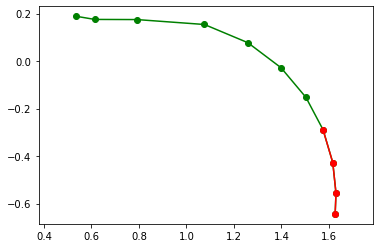

In [25]:
f = plt.figure()
a = f.add_subplot(111)

#for item in path[range_min:range_max]:
#    plot_mechanism(item)
#y_out=p2[7:11,:]
#y_out

a.plot(p2[:,0],p2[:,1],'go-')    
a.plot(y_out[:,0],y_out[:,1],'ro-')    
plt.axis('equal')
plt.savefig('f3.png')

In [26]:
dy = y_out[2:,:]-y_out[:-2,:]
dq = q_in[2:]-q_in[:-2]

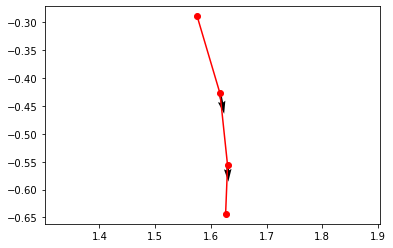

In [27]:
plt.figure()
plt.plot(y_out[:,0],y_out[:,1],'ro-')    
plt.quiver(y_out[1:-1,0],y_out[1:-1,1],dy[:,0],dy[:,1])
plt.axis('equal')
plt.show()

In [28]:
J=(dy.T/dq.T)
J.shape

(2, 2)

Then the Jacobian was solved for resulting in the following:

In [29]:
J

array([[ 0.00272964,  0.00050313],
       [-0.01337378, -0.01081198]])

Estimated total mass of the system is .33 kg however with force distribution across the 4 limbs, the total mass expected on one leg is .132kg. This is used to calculate forces on the system as well as torques and estimated velocity of the end effector.

In [30]:
m = .132 #kg
g = 9.81 #m/s^2
fx = m*g
fy = -m*g
f = numpy.array([[fx,fy]]).T
t = J.T.dot(f)
t #N-m

motor_speed = 130#rpm
dq_dt = motor_speed*2*math.pi/60
velocity = J*dq_dt

velocity[0,:]

f
P = t.dot(dq_dt)
P

array([[0.28387882],
       [0.19946812]])

## 6. From your biomechanics-based specifications, define one or more force vector estimates (one for each end effector) that the system should be expected to experience.

>The vertical force of the rear foot is 0.4 of the body weight of the salamander.[1] The rest is supported by the front foot and the tail. We are estimating the weight of the robot to be 0.33 KG. This would be approximately 1.3N

## 7. Calculate the force or torque required at the input to satisfy the end-effector force requirements

>Based on our calculations the estimated input torque would need to be 0.021 Nm to achieve 1.3N on the end effector

## 8. Estimate the velocity of the end-effector in this configuration. Using the Jacobian, calculate the speed required by the input(s) to achieve that output motion.
>The end effector would have an estimated speed of 37.7 m-3/s 

## 9. Discussion

### 1. How many degrees of freedom does your device have? How many motors? If the answer is not the same, what determines the state of the remaining degrees of freedom? How did you arrive at that number?

> The device has a pair of legs. Two 4-bar linkages that share a common vertex inline with the motor axle. Each pair has a single degree of freedom and  operates in opposite directions. They are controlled by a single motor.


### 2. If your mechanism has more than one degree of freedom, please describe how those multiple degrees of freedom will work together to create a locomotory gait or useful motion. What is your plan for synchronizing, especially if passive energy storage?
>¯\_( ͡❛ ͜ʖ ͡❛)_/¯
 

### 3. How did you estimate your expected end-effector forces

> The robot needs to old up its own weight, hence -m*g force in y

> Assuming 1g acceleration horizontally, m*g force in x
 
### 4. How did you estimate your expected end-effector speeds

> Max walking velocity: 10.5 cms-1 <br>Stride length: 1.07 <br>=> 9.81 steps/sec <br>Assuming two rotations per step per leg, roughly 5 rotations of motor per second.

> which gives us motor speed that can be used to calculate qd

> and end-effector velocity can be calculated as: velocity = J*dq_dt